# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [9]:
num_classes = 10 # загаль кількість на кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 #атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.01 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [10]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [11]:
# Створимо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(784, 128)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(128, 256)
        # Вихідний шар
        self.output_layer = DenseLayer(256, num_classes)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x, activation='relu')
        x = self.layer2(x, activation='sigmoid')
        x = self.output_layer(x, activation='softmax')
        return x

In [12]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    # Перетворити передбачення в бінарний формат (0 або 1)
    y_pred_labels = tf.argmax(y_pred, axis=1)

    # Обчислення точності
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_labels, y_true), tf.float32))
    return accuracy

In [13]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.Adam(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Отримання списку оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислення градієнтів відносно параметрів
    gradients = g.gradient(loss, trainable_variables)

    # Оновлення параметрів за допомогою оптимізатора
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss


In [14]:
# Тренування мережі
loss_history = []
accuracy_history = []

# Приклад: припускаємо, що train_data — це tf.data.Dataset об'єкт, вже визначений раніше
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = loss.numpy()
        # Перетворення batch_y на int32 перед обчисленням точності
        current_accuracy = accuracy(pred, tf.cast(batch_y, tf.int64)).numpy()
        loss_history.append(current_loss)
        accuracy_history.append(current_accuracy)
        print(f"Step {step}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}")

Step 100, Loss: 310.5800, Accuracy: 0.8086
Step 200, Loss: 161.5139, Accuracy: 0.8828
Step 300, Loss: 166.8228, Accuracy: 0.8633
Step 400, Loss: 96.7723, Accuracy: 0.9258
Step 500, Loss: 109.3619, Accuracy: 0.9375
Step 600, Loss: 107.3350, Accuracy: 0.9258
Step 700, Loss: 65.6205, Accuracy: 0.9648
Step 800, Loss: 88.3178, Accuracy: 0.9336
Step 900, Loss: 81.5916, Accuracy: 0.9453
Step 1000, Loss: 80.0182, Accuracy: 0.9531
Step 1100, Loss: 75.4170, Accuracy: 0.9570
Step 1200, Loss: 86.6396, Accuracy: 0.9336
Step 1300, Loss: 120.9589, Accuracy: 0.9180
Step 1400, Loss: 82.5888, Accuracy: 0.9414
Step 1500, Loss: 103.5740, Accuracy: 0.9375
Step 1600, Loss: 88.6058, Accuracy: 0.9336
Step 1700, Loss: 65.4348, Accuracy: 0.9609
Step 1800, Loss: 65.1647, Accuracy: 0.9648
Step 1900, Loss: 103.7039, Accuracy: 0.9258
Step 2000, Loss: 71.6142, Accuracy: 0.9531
Step 2100, Loss: 82.7912, Accuracy: 0.9531
Step 2200, Loss: 80.2939, Accuracy: 0.9492
Step 2300, Loss: 93.7027, Accuracy: 0.9414
Step 2400, L

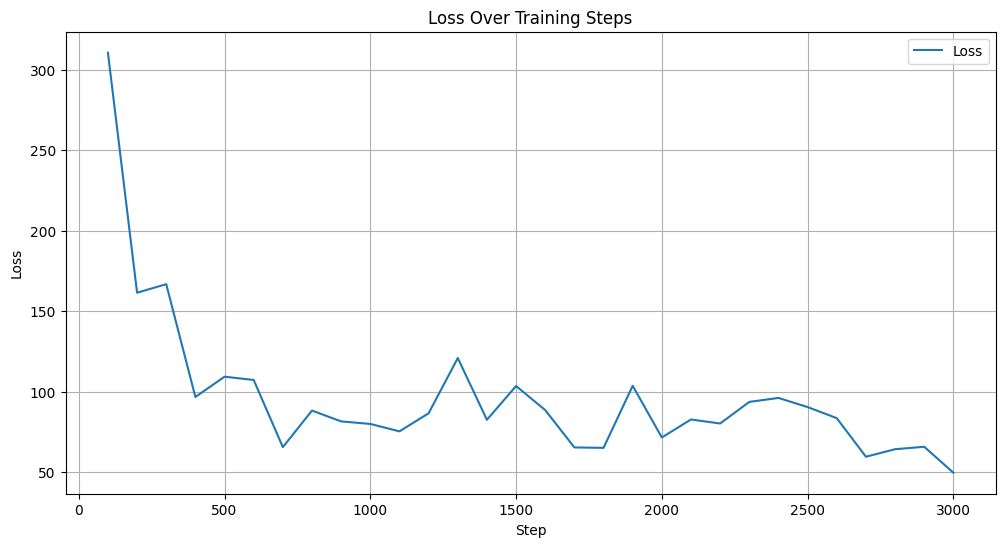

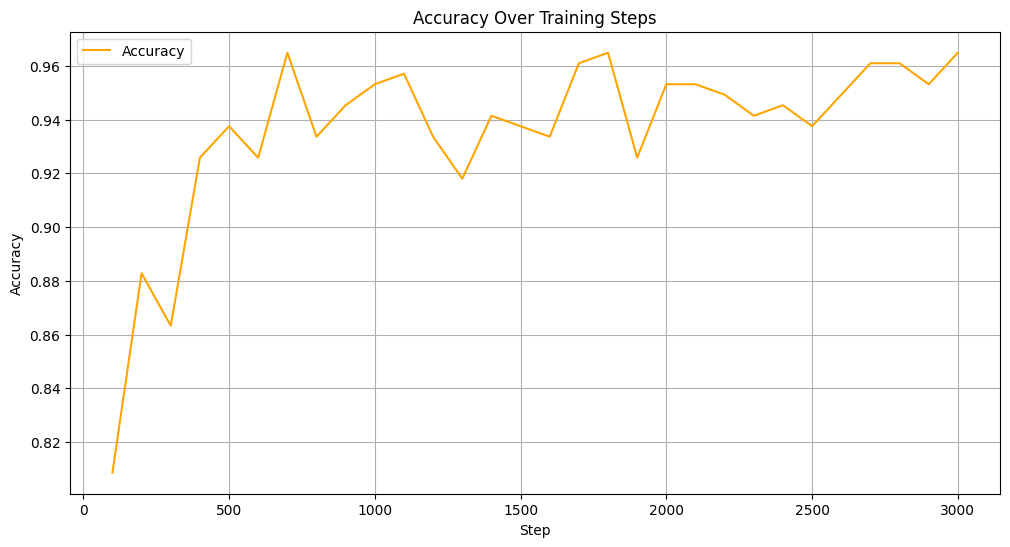

In [15]:
import matplotlib.pyplot as plt

# Виведення графіка функції втрат
plt.figure(figsize=(12, 6))
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss Over Training Steps')
plt.legend()
plt.grid(True)
plt.show()

# Виведення графіка точності
plt.figure(figsize=(12, 6))
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, label='Accuracy', color='orange')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Training Steps')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Обчисліть точність навченої нейромережі
# Обчислення точності на тренувальних даних
train_pred = neural_net(x_train)
train_accuracy = accuracy(train_pred, tf.cast(y_train, tf.int64)).numpy()
print(f"Training Accuracy: {train_accuracy}")

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, tf.cast(y_test, tf.int64)).numpy()
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9453166723251343
Test Accuracy: 0.9387000203132629


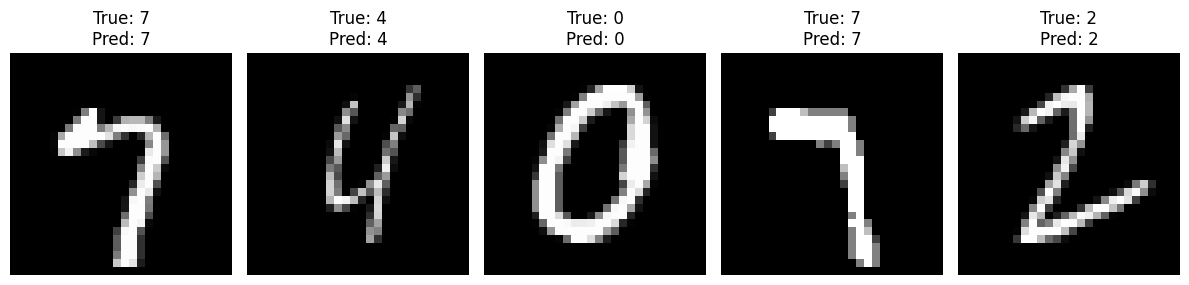

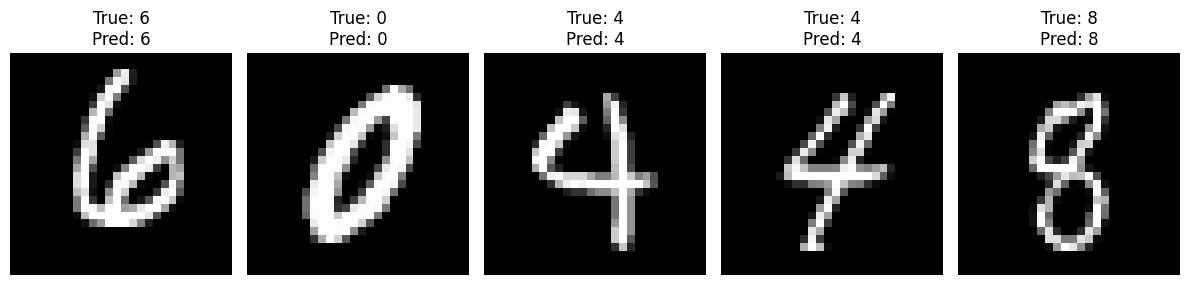

Correct predictions for first set: 5/5
Incorrect predictions for first set: 0/5
Correct predictions for second set: 5/5
Incorrect predictions for second set: 0/5


In [17]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# import random
import matplotlib.pyplot as plt

# Вибираємо 5 випадкових зображень із тестової вибірки
random_indices = random.sample(range(x_test.shape[0]), 5)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

# Передаємо ці зображення до нейронної мережі
predictions = neural_net(random_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виведемо зображення та відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {random_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Аналогічно, для інших 5 зображень із тестової вибірки
additional_indices = random.sample(range(x_test.shape[0]), 5)
additional_images = x_test[additional_indices]
additional_labels = y_test[additional_indices]

# Передаємо ці зображення до нейронної мережі
additional_predictions = neural_net(additional_images)
additional_predicted_labels = tf.argmax(additional_predictions, axis=1).numpy()

# Виведемо зображення та відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(additional_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {additional_labels[i]}\nPred: {additional_predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Зробіть висновок про те, чи помиляється нейронна мережа, і якщо так, то як часто
correct_predictions = np.sum(predicted_labels == random_labels)
incorrect_predictions = 5 - correct_predictions

additional_correct_predictions = np.sum(additional_predicted_labels == additional_labels)
additional_incorrect_predictions = 5 - additional_correct_predictions

print(f"Correct predictions for first set: {correct_predictions}/5")
print(f"Incorrect predictions for first set: {incorrect_predictions}/5")

print(f"Correct predictions for second set: {additional_correct_predictions}/5")
print(f"Incorrect predictions for second set: {additional_incorrect_predictions}/5")




In [18]:
from sklearn.metrics import classification_report
y_pred = neural_net(x_test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
report = classification_report(y_test, y_pred_labels, target_names=[str(i) for i in range(num_classes)])

print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.97      0.97      1135
           2       0.91      0.94      0.92      1032
           3       0.93      0.92      0.93      1010
           4       0.92      0.93      0.92       982
           5       0.92      0.93      0.92       892
           6       0.98      0.94      0.96       958
           7       0.95      0.94      0.94      1028
           8       0.91      0.92      0.92       974
           9       0.94      0.90      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



**Висновок:**
Змінила оптимізатор (Adam), активатор (relu). Значення точності в тестових (0.93) даних практично не відрізнялися від навчальних (0.94). При тестуванні навченої нейромережу на 10 зображеннях - 7 з навчальної та 3 з тестової вибірок правильне передбачення склало 5 з 5. Оцінки метрик якості також вийшли досить високі (0.94).
